# 2019-10-01_facial-keypoints-detection_01

## Links

Tutorial:

In [1]:
%matplotlib inline

import pathlib
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pyprojroot import here

In [2]:
root_p = here(proj_files=[".here"])
train_p = root_p / "020_data/training.csv"
test_p = root_p / "020_data/test.csv"

## Import data

In [3]:
train_df = pd.read_csv(train_p)
test_df = pd.read_csv(test_p)
train_df.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

## Helper functions

In [4]:
def plot_img(img_data: Union[str, np.ndarray]) -> None:
    """Plot an image.
    
    The image data can be supplied as str or np.ndarray.
    
    """
    if isinstance(img_data, str):
        img = np.array(img_data.split(), dtype=np.uint8).reshape(96, 96)
    else:
        img = img_data.reshape(96, 96)
    
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    
def plot_facial_keypoints(dataset: pd.Series) -> None:
    """Plot the whole dataset with facial keypoints"""
    plot_img(dataset.Image)
    for i in range(0, 30, 2):
        x, y = dataset[i], dataset[i+1]
        plt.plot(x, y, "or")

## Let's look at the data

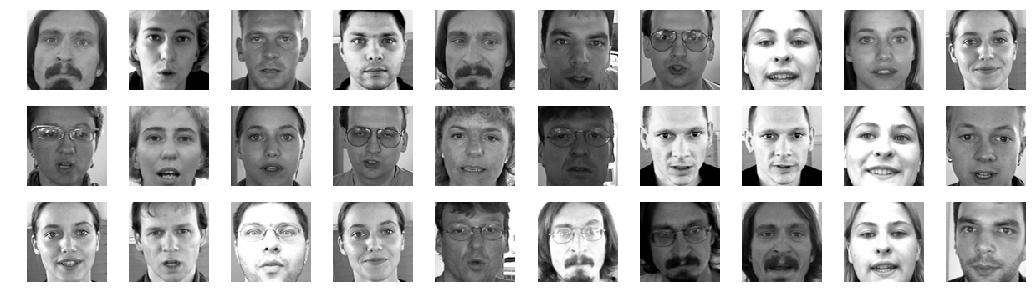

In [5]:
fig = plt.figure(figsize=(18, 5))

for i in range(30):
    ax = fig.add_subplot(3, 10, i+1)
    plot_img(train_df.iloc[i].Image)

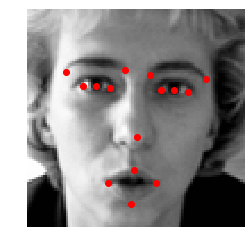

In [6]:
plot_facial_keypoints(train_df.iloc[1])

## Let's begin with the tip of the nose

In [7]:
X_train = np.array([np.array(a.split(), dtype=np.uint8) / 255.0 for a in train_df.Image.values])
Y_train = train_df[["nose_tip_x", "nose_tip_y"]].values / 96.0

In [8]:
X_test = np.array([np.array(a.split(), dtype=np.uint8) / 255.0 for a in test_df.Image.values])

In [11]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.activations import tanh
from keras_tqdm import TQDMNotebookCallback

In [12]:
model = Sequential([
    Dense(200, activation="tanh"),
    Dense(100, activation="tanh"),
    Dense(50, activation="tanh"),
    Dense(2)
])
model.compile(Adam(lr=0.00001), loss="mse")

In [13]:
history = model.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=64,
    verbose=0,
    callbacks=[TQDMNotebookCallback(metric_format="{value:.6f}")]
)

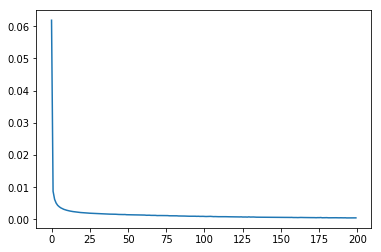

In [14]:
plt.plot(history.history["loss"])

In [15]:
y_pred = model.predict(np.array([X_train[0]]))
np.sqrt(1/y_pred.shape[1] * np.sum(np.square(y_pred - Y_train[0]))) * 96

1.9196567227349317

In [16]:
import ipywidgets as widgets
from ipywidgets import interact

In [17]:
def f(i):
    y_pred = model.predict(np.array([X_test[i]])) * 96
    plt.plot(y_pred[0][0], y_pred[0][1], "or")
    plt.imshow((X_test[i] * 255).astype(np.uint8).reshape(96, 96), cmap="gray")
    
interact(f, i=widgets.IntSlider(10, min=0, max=100))

interactive(children=(IntSlider(value=10, description='i'), Output()), _dom_classes=('widget-interact',))

<function __main__.f(i)>

In [22]:
results_p = here("030_results")
model.save_weights(str(results_p / "weights01_tf1.14_keras2.3.0.h5"))